# CMR Multi-Parameter Sweep

1. Setup
2. Simulation function
3. Analysis metrics
4. Visualization functions
5. Sweep function
6. Run sweeps (B_rec, gamma_fc, eta, B_encD_scale)

---
## Setup

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import defaultdict
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)


### List Configuration

In [44]:
# List length and presentation order
N = 10
pres_indices = np.random.permutation(N) + 1  # 1-indexed

# Sequence values (not used in basic CMR)
sequence = np.array([50, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45])

### Base Parameters

`BASE_PARAMS` contains defaults for all sweepable parameters.

In [45]:
# === Base Parameters (defaults when NOT sweeping) ===
BASE_PARAMS = {
    "B_rec": 0.55,              # Retrieval context drift
    "gamma_fc": 0.581,          # Pre-existing association strength
    "eta": 0.3699,              # Accumulator noise
    "B_encD_scale": 1.0,        # Encoding drift multiplier
}

# === Parameter Grids for Sweeping ===
B_rec_grid = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
gamma_fc_grid = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
eta_grid = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
B_encD_scale_grid = [0.2, 0.4, 0.6, 0.8, 1.0]

BASE_SEED = 2026
n_sims = 1000


### Retrieval Route Weights

In [46]:
sem = 0
episodic = 1

sem_weight = sem / (episodic + sem)
episodic_weight = episodic / (episodic + sem)


### Context Drift & Semantic Matrix

In [47]:
# Encoding drift schedule
B_encD = np.array([1.0, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65])

# Semantic matrix (orthogonal item features)
sem_mat = np.eye(N)


### Fixed Parameters

In [48]:
# These remain constant across all sweeps
lrate_cf_enc = 1.0
lrate_fc_rec = 0.0
lrate_cf_rec = 0.0

# Accumulator dynamics
thresh = 1.0
rec_time = 90000  # ms
dt = 100          # ms
tau = 413         # ms
K = 0.091
L = 0.375

---
## Simulation Functions

### Single-trial runner

- Runs one complete encoding phase + retrieval phase.
- Builds the episodic weight matrices `net_w_fc`, `net_w_cf` from scratch each time (initialized using `gamma_fc_val` and then updated during encoding/retrieval).
- Applies the encoding drift schedule as:
    - `B_encD_local = B_encD * B_encD_scale`
    - then uses `B = B_encD_local[item_idx]` inside the encoding context update loop.
- Retrieval uses `B_rec` in the context update after each recalled item.
- For diagnostics:
    - Logs the radicand rad, rho, dot, ||c||, cos_after per successful recall (these are the quantities you’ll plot against recall step).
    - Logs evidence summaries right before the accumulator each outer loop:
        - `f_max`, `f_entropy` (peakedness), and `f_recency_mass` (softmax mass on last recency_k items).
    - Logs the recall path: serial_pos, lag, time.

In [102]:
from collections import defaultdict

def simulate_single_trial(
    B_rec,
    rng,
    gamma_fc_val=None,
    eta_val=None,
    B_encD_scale=1.0,
    record_diagnostics=False,
    recency_k=3
):
    """
    Simulate one encoding–retrieval trial (CMR-style).

    Parameters
    ----------
    B_rec : float
        Context drift rate during retrieval.
    rng : numpy.random.Generator
        Random number generator.
    gamma_fc_val : float, optional
        Pre-existing association strength (if None, uses BASE_PARAMS["gamma_fc"]).
    eta_val : float, optional
        Accumulator noise (if None, uses BASE_PARAMS["eta"]).
    B_encD_scale : float, optional
        Multiplier for encoding drift schedule B_encD (per-serial-position drift).
    record_diagnostics : bool
        If True, record cue advantage diagnostics AND internal retrieval traces.
    recency_k : int
        How many final serial positions count as "recency" for evidence mass diagnostic.

    Returns
    -------
    recalls : (N,) array
        Serial positions recalled in order (0-filled past recall_count).
    times : (N,) array
        Recall times for each output position (0-filled past recall_count).
    net_w_fc : (N,N) array
        Final item->context weights.
    net_w_cf : (N,N) array
        Final context->item weights.
    diagnostics : dict or None
        If record_diagnostics=True, returns dict with:
          - "cue": neighbor cue advantage diagnostics
          - "trace": internal traces (rad, dot, rho, c_norm, cos_after, evidence summaries,
                     and mean evidence by serial position: f_mean_by_pos, f_mean_centered_by_pos)
        Otherwise None.
    """

    # ---- params ----
    if gamma_fc_val is None:
        gamma_fc_val = BASE_PARAMS["gamma_fc"]
    if eta_val is None:
        eta_val = BASE_PARAMS["eta"]

    # derived params (recomputed if gamma_fc changes)
    eye_fc_local = 1.0 - gamma_fc_val
    eye_cf_local = 0.0
    lrate_fc_enc_local = gamma_fc_val

    # scale encoding drift schedule
    B_encD_local = B_encD * B_encD_scale

    # ================== INITIALIZATION ==================
    net_f = np.zeros((N, 1))
    net_c = np.zeros((N, 1))

    # initialize weights with pre-existing associations
    net_w_fc = np.eye(N) * eye_fc_local
    net_w_cf = np.eye(N) * eye_cf_local

    # ================== ENCODING PHASE ==================
    for item_idx in range(N):
        feature_idx = int(pres_indices[item_idx] - 1)

        net_f[:] = 0
        net_f[feature_idx] = 1

        # Context input through M_FC
        net_c_in = net_w_fc @ net_f
        net_c_in = net_c_in / float(np.sqrt(net_c_in.T @ net_c_in))

        # Context update (encoding drift schedule)
        c_in, c = net_c_in, net_c
        B = float(B_encD_local[item_idx])
        dot = float(c.T @ c_in)
        rad = 1.0 + (B**2) * ((dot**2) - 1.0)
        rho = np.sqrt(rad) - B * dot

        net_c = rho * c + B * c_in

        # Weight updates
        net_w_fc += (net_c @ net_f.T) * lrate_fc_enc_local
        net_w_cf += (net_f @ net_c.T) * lrate_cf_enc

    # ================== RETRIEVAL SETUP ==================
    recalls = np.zeros((N, 1))
    times = np.zeros((N, 1))

    retrieved = np.zeros((N, 1), dtype=bool)
    thresholds = np.ones((N, 1))

    net_weights = episodic_weight * net_w_cf + sem_weight * sem_mat

    time_passed = 0.0
    recall_count = 0

    # ---- diagnostics containers ----
    diagnostics = None
    cue_diag = None
    trace = None

    if record_diagnostics:
        # cue advantage diagnostics
        deltas_all = []
        deltas_by_pos = defaultdict(list)
        delta_forward = []
        delta_backward = []
        pending = None

        # internal traces (per successful recall update + per retrieval attempt)
        trace = {
            # per successful recall update
            "dot": [],
            "rad": [],
            "rho": [],
            "c_norm": [],
            "cos_after": [],

            # per retrieval attempt (before accumulator)
            "f_max": [],
            "f_entropy": [],
            "f_recency_mass": [],

            # mean evidence by SERIAL POSITION across retrieval attempts (per trial)
            "f_mean_by_pos": None,
            "f_mean_centered_by_pos": None,
        }

        # accumulate evidence-by-position across retrieval attempts in this trial
        f_sum_by_pos = np.zeros(N, dtype=float)
        f_count = 0

    # ================== RETRIEVAL LOOP ==================
    while time_passed < rec_time:

        # evidence vector for accumulator
        f_in = net_weights @ net_c  # (N,1)

        # ---- log evidence summaries BEFORE accumulator ----
        if record_diagnostics:
            f = f_in.flatten().astype(float)

            # stable softmax
            f_shift = f - np.nanmax(f)
            expf = np.exp(f_shift)
            Z = np.nansum(expf)
            if not np.isfinite(Z) or Z <= 0:
                p = np.full_like(f, np.nan)
            else:
                p = expf / Z

            # recency mass in SERIAL POSITION space (last recency_k serial positions)
            k = int(recency_k)
            k = max(1, min(N, k))
            rec_pos0 = np.arange(N - k, N)  # 0-indexed serial positions

            # map serial position -> item index (feature index)
            rec_item_idx = [int(pres_indices[pos0] - 1) for pos0 in rec_pos0]
            rec_mass = np.nansum(p[rec_item_idx])

            # entropy and max
            ent = -np.nansum(p * np.log(p + 1e-12))
            fmax = np.nanmax(f)

            trace["f_recency_mass"].append(float(rec_mass))
            trace["f_entropy"].append(float(ent))
            trace["f_max"].append(float(fmax))

            # evidence-by-serial-position (raw, not softmax)
            f_pos = np.empty(N, dtype=float)
            for pos0 in range(N):
                item_idx = int(pres_indices[pos0] - 1)
                f_pos[pos0] = f[item_idx]
            f_sum_by_pos += f_pos
            f_count += 1

        # accumulator setup
        max_cycles = int((rec_time - time_passed) / dt)
        dt_tau = dt / tau
        sq_dt_tau = np.sqrt(dt_tau)

        # pre-generate noise
        noise = rng.normal(0, eta_val * sq_dt_tau, size=(N, max_cycles))

        eyeI = ~np.eye(N, dtype=bool)
        lmat = eyeI.astype(float) * L

        x = np.zeros((N, 1))
        K_array = np.ones((N, 1)) * K
        inds = np.arange(N)

        crossed = 0
        i = 0

        while i < max_cycles and crossed == 0:

            lx = lmat @ x
            kx = K_array * x

            x = x + ((f_in - kx - lx) * dt_tau + noise[:, i:i+1])
            x[x < 0] = 0

            reset_these = retrieved & (x >= thresholds)
            x[reset_these] = 0.95 * thresholds[reset_these]

            retrievable = ~retrieved

            if np.any(x[retrievable] >= thresholds[retrievable]):
                crossed = 1
                temp_win = x[retrievable] >= thresholds[retrievable]
                temp_ind = inds[retrievable.flatten()]
                winners = temp_ind[temp_win.flatten()]

                if len(winners) > 1:
                    winners = np.array([rng.choice(winners)])

            i += 1

        time_passed += i * dt

        # ================== ON SUCCESSFUL RECALL ==================
        if crossed == 1:
            winner = int(winners[0])

            # map feature index -> serial position in the presented order
            serial_pos0 = int(np.where(pres_indices - 1 == winner)[0][0])
            serial_pos1 = serial_pos0 + 1  # 1-indexed

            # cue-transition bookkeeping (uses previous step's delta_f)
            if record_diagnostics and pending is not None:
                prev_pos0 = pending["serial_pos0"]
                delta_f_prev = pending["delta_f"]
                transition = serial_pos0 - prev_pos0

                if transition == 1:
                    delta_forward.append(delta_f_prev)
                elif transition == -1:
                    delta_backward.append(delta_f_prev)

                pending = None

            # Reactivate recalled item feature
            net_f[:] = 0
            net_f[winner] = 1

            # Context input
            net_c_in = net_w_fc @ net_f
            net_c_in = net_c_in / float(np.sqrt(net_c_in.T @ net_c_in))

            # Retrieval context update
            c_in, c = net_c_in, net_c
            dot = float(c.T @ c_in)
            rad = 1.0 + (B_rec**2) * ((dot**2) - 1.0)
            rho = np.sqrt(rad) - B_rec * dot  # becomes NaN if rad < 0

            net_c = rho * c + B_rec * c_in

            # log post-update stability quantities
            if record_diagnostics:
                trace["dot"].append(float(dot))
                trace["rad"].append(float(rad))
                trace["rho"].append(float(rho) if np.isfinite(rho) else np.nan)

                c_norm = float(np.sqrt(net_c.T @ net_c)) if np.all(np.isfinite(net_c)) else np.nan
                trace["c_norm"].append(c_norm)

                # cosine similarity after update (how "locked" c is to c_in)
                if np.isfinite(c_norm) and c_norm > 0 and np.all(np.isfinite(c_in)):
                    cin_norm = float(np.sqrt(c_in.T @ c_in))
                    cos_after = float((net_c.T @ c_in) / (c_norm * cin_norm))
                else:
                    cos_after = np.nan
                trace["cos_after"].append(cos_after)

            # weight updates during retrieval
            net_w_fc += (net_c @ net_f.T) * lrate_fc_rec
            net_w_cf += (net_f @ net_c.T) * lrate_cf_rec

            # record recall
            recall_count += 1
            recalls[recall_count - 1, 0] = serial_pos1
            times[recall_count - 1, 0] = time_passed

            # Cue advantage diagnostics (neighbor advantage)
            if record_diagnostics:
                left_pos0 = serial_pos0 - 1
                right_pos0 = serial_pos0 + 1

                if 0 <= left_pos0 < N and 0 <= right_pos0 < N:
                    left_item = int(pres_indices[left_pos0] - 1)
                    right_item = int(pres_indices[right_pos0] - 1)

                    if (not retrieved[left_item]) and (not retrieved[right_item]):
                        f_after = (net_weights @ net_c).flatten()
                        delta_f = float(f_after[right_item] - f_after[left_item])

                        deltas_all.append(delta_f)
                        deltas_by_pos[serial_pos1].append(delta_f)
                        pending = {"serial_pos0": serial_pos0, "delta_f": delta_f}

            retrieved[winner] = True

    # ================== per-trial DIAGNOSTICS ==================
    if record_diagnostics:
        cue_diag = {
            "deltas_all": deltas_all,
            "deltas_by_pos": dict(deltas_by_pos),
            "delta_forward": delta_forward,
            "delta_backward": delta_backward,
        }

        # per-trial mean evidence by serial position across retrieval attempts
        if f_count > 0:
            f_mean_by_pos = f_sum_by_pos / f_count
            f_mean_centered_by_pos = f_mean_by_pos - np.mean(f_mean_by_pos)
        else:
            f_mean_by_pos = np.full(N, np.nan, dtype=float)
            f_mean_centered_by_pos = np.full(N, np.nan, dtype=float)

        trace["f_mean_by_pos"] = f_mean_by_pos
        trace["f_mean_centered_by_pos"] = f_mean_centered_by_pos

        diagnostics = {
            "cue": cue_diag,
            "trace": trace
        }

    return recalls.flatten(), times.flatten(), net_w_fc, net_w_cf, diagnostics

### Batch runner


Run many independent sims and return the raw simulation outputs stacked into arrays. Returns:
- `recall_sims`: an `N × n_sims` matrix (each column = one simulated list’s recall sequence; often padded with 0s for “no recall”)
- `times_sims`: an `N × n_sims` matrix of recall times.
- `net_w_fc`, `net_w_cf` from the last sim (not averaged)

In [50]:
def run_simulation(B_rec, n_sims=500, seed=2026, gamma_fc_val=None, eta_val=None, B_encD_scale=1.0):
    """
    Run multiple independent trials.
    
    Parameters
    ----------
    B_rec : float
        Retrieval context drift
    n_sims : int
        Number of simulations
    seed : int
        Random seed
    gamma_fc_val : float, optional
        Pre-existing association strength
    eta_val : float, optional
        Accumulator noise
    B_encD_scale : float, optional
        Encoding drift multiplier
    
    Returns
    -------
    recall_sims, times_sims, net_w_fc, net_w_cf
    """
    rng = np.random.default_rng(seed)
    
    recall_sims = np.zeros((N, n_sims), dtype=int)
    times_sims = np.zeros((N, n_sims), dtype=float)
    
    net_w_fc_last = None
    net_w_cf_last = None
    
    for s in range(n_sims):
        recalls, times, net_w_fc, net_w_cf, _ = simulate_single_trial(
            B_rec=B_rec,
            rng=rng,
            gamma_fc_val=gamma_fc_val,
            eta_val=eta_val,
            B_encD_scale=B_encD_scale,
            record_diagnostics=False
        )
        
        recall_sims[:, s] = recalls.astype(int)
        times_sims[:, s] = times
        
        net_w_fc_last = net_w_fc
        net_w_cf_last = net_w_cf
    
    return recall_sims, times_sims, net_w_fc_last, net_w_cf_last

### Batch runner recording per-trial diagnostic traces

In [103]:
def run_simulation_with_traces(
    B_rec, n_sims=500, seed=2026,
    gamma_fc_val=None, eta_val=None, B_encD_scale=1.0,
    recency_k=3
):
    """
    Run multiple independent trials and store retrieval stability traces.

    Returns
    -------
    recall_sims, times_sims, net_w_fc_last, net_w_cf_last, trace_sims
      trace_sims is a list of length n_sims, each element is diagnostics["trace"].
    """
    rng = np.random.default_rng(seed)

    recall_sims = np.zeros((N, n_sims), dtype=int)
    times_sims = np.zeros((N, n_sims), dtype=float)

    net_w_fc_last = None
    net_w_cf_last = None
    trace_sims = []

    for s in range(n_sims):
        recalls, times, net_w_fc, net_w_cf, diag = simulate_single_trial(
            B_rec=B_rec,
            rng=rng,
            gamma_fc_val=gamma_fc_val,
            eta_val=eta_val,
            B_encD_scale=B_encD_scale,
            record_diagnostics=True,
            recency_k=recency_k
        )

        recall_sims[:, s] = recalls.astype(int)
        times_sims[:, s] = times

        net_w_fc_last = net_w_fc
        net_w_cf_last = net_w_cf

        # store trace (could be None if something unexpected happens)
        trace_sims.append(diag["trace"] if (diag is not None and "trace" in diag) else None)

    return recall_sims, times_sims, net_w_fc_last, net_w_cf_last, trace_sims

---
## Behavioral Analysis Metrics

### SPC, PFR, lag-CRP

In [ ]:
def compute_spc(recall_sims, N):
    """Serial Position Curve."""
    spc = np.zeros(N)
    for j in range(1, N + 1):
        spc[j - 1] = np.mean(np.any(recall_sims == j, axis=0))
    return spc


def compute_pfr(recall_sims, N):
    """Probability of First Recall."""
    first = recall_sims[0, :]
    first = first[first > 0]
    
    pfr = np.zeros(N)
    if len(first) > 0:
        for j in range(1, N + 1):
            pfr[j - 1] = np.mean(first == j)
    return pfr


def compute_lag_crp(recall_sims, N):
    """Lag-CRP with opportunity correction."""
    max_lag = N - 1
    lag_vals = np.arange(-max_lag, max_lag + 1)
    
    numer = np.zeros(len(lag_vals), dtype=float)
    denom = np.zeros(len(lag_vals), dtype=float)
    
    lag_to_idx = {L: i for i, L in enumerate(lag_vals)}
    
    for s in range(recall_sims.shape[1]):
        seq = recall_sims[:, s]
        seq = seq[seq > 0].astype(int)
        
        if len(seq) < 2:
            continue
        
        recalled = set()
        
        for t in range(len(seq) - 1):
            cur = seq[t]
            nxt = seq[t + 1]
            
            recalled.add(cur)
            remaining = [j for j in range(1, N + 1) if j not in recalled]
            
            for j in remaining:
                L = j - cur
                denom[lag_to_idx[L]] += 1
            
            L_obs = nxt - cur
            numer[lag_to_idx[L_obs]] += 1
    
    crp = np.zeros_like(numer)
    valid = denom > 0
    crp[valid] = numer[valid] / denom[valid]
    
    return lag_vals, crp

### lag-CRP diagnostics

#### lag-CRP denominator & numerator

In [140]:
def lag_crp_with_counts(recall_sims, N):
    """
    Returns:
      lags: array of lags from -(N-1) .. (N-1), excluding 0
      crp: conditional probs
      num: numerator counts (# realized transitions)
      den: denominator opportunity counts (# possible transitions given what's left)
    Assumes recall_sims columns are trials, entries are serial positions (1..N), 0 for no recall.
    """
    lag_list = [l for l in range(-(N-1), N) if l != 0]
    idx = {l:i for i,l in enumerate(lag_list)}
    num = np.zeros(len(lag_list), dtype=float)
    den = np.zeros(len(lag_list), dtype=float)

    for s in range(recall_sims.shape[1]):
        r = recall_sims[:, s]
        r = r[r > 0]  # keep recalled serial positions
        if len(r) < 2:
            continue

        recalled = set()
        for t in range(len(r) - 1):
            i = int(r[t])      # current serial position (1..N)
            j = int(r[t+1])    # next
            recalled.add(i)

            remaining = set(range(1, N+1)) - recalled
            # opportunities: for each possible lag l, is i+l still available?
            for l in lag_list:
                k = i + l
                if 1 <= k <= N and (k in remaining):
                    den[idx[l]] += 1

            # realized transition:
            l_real = j - i
            if l_real != 0 and l_real in idx:
                num[idx[l_real]] += 1

    crp = np.divide(num, den, out=np.full_like(num, np.nan), where=den > 0)
    return np.array(lag_list), crp, num, den

#### Conditional lag rates

At each transition step with current item $i$, define the remaining unrecalled set $R$. A lag $\ell$ is an *opportunity* if $i+\ell \in R$ and $1\le i+\ell \le N$.
Aggregating over all steps and trials yields:
- Numerator counts: $$\text{num}(\ell)=\#\{\text{observed transitions with lag } \ell\}.$$
- Denominator counts: $$\text{den}(\ell)=\#\{\text{opportunities for lag } \ell\}.$$

The lag-CRP is
$$\text{CRP}(\ell)=\frac{\text{num}(\ell)}{\text{den}(\ell)} \quad (\text{when } \text{den}(\ell)>0).$$

Scalar conditional rates are “ratio of sums” over lag bins:
- Lag-1: $$P(|\ell|=1\mid \text{opp})=\frac{\sum_{|\ell|=1}\text{num}(\ell)}{\sum_{|\ell|=1}\text{den}(\ell)}.$$
- Large-lag ($k$): $$P(|\ell|\ge k\mid \text{opp})=\frac{\sum_{|\ell|\ge k}\text{num}(\ell)}{\sum_{|\ell|\ge k}\text{den}(\ell)}.$$

A conditional *shape* summary of mean $|\ell|$ can be computed by normalizing the CRP profile:
$$p(\ell)=\frac{\text{CRP}(\ell)}{\sum_{m}\text{CRP}(m)}, \qquad \mathbb{E}_{\text{CRP}}[|\ell|]=\sum_{\ell}|\ell|\,p(\ell).$$
This isolates how the conditional lag profile emphasizes small vs large lags.

In [155]:
def conditional_lag_rates_from_counts(lags, num, den, large_lag_thresh=4):
    """
    Opportunity-corrected scalar summaries consistent with lag-CRP.

    Returns:
      lag_one   = sum_num(|lag|=1) / sum_den(|lag|=1)
      large_lag = sum_num(|lag|>=k) / sum_den(|lag|>=k)
      mean_abs_cond = E_CRP[|lag|] where CRP(lag)=num/den is normalized over lags
                      (a shape summary of the CRP profile).
    """
    lags = np.asarray(lags, dtype=int)
    num  = np.asarray(num, dtype=float)
    den  = np.asarray(den, dtype=float)

    valid = (lags != 0) & (den > 0)

    # --- lag-1 conditional rate ---
    lag1 = valid & (np.abs(lags) == 1)
    den_lag1 = den[lag1].sum()
    lag_one = (num[lag1].sum() / den_lag1) if den_lag1 > 0 else np.nan

    # --- large-lag conditional rate ---
    large = valid & (np.abs(lags) >= large_lag_thresh)
    den_large = den[large].sum()
    large_lag = (num[large].sum() / den_large) if den_large > 0 else np.nan

    # --- CRP-profile mean |lag| (normalize CRP over lags) ---
    crp = np.divide(num, den, out=np.full_like(num, np.nan), where=den > 0)
    crp_valid = crp[valid]
    lags_valid = lags[valid]

    Z = np.nansum(crp_valid)
    if np.isfinite(Z) and Z > 0:
        p = crp_valid / Z
        mean_abs_cond = np.nansum(np.abs(lags_valid) * p)
    else:
        mean_abs_cond = np.nan

    return lag_one, large_lag, mean_abs_cond

#### Unconditional lag rates

From each trial’s recall sequence $(r_1,r_2,\dots,r_T)$ (after dropping zeros), compute observed lags
$${\ell_t = r_{t+1}-r_t \quad \text{for } t=1,\dots,T-1, \ \ell_t\neq 0.}$$

Pooling all observed $\ell_t$ across trials gives:
- Lag-1 rate: $$P(|\ell|=1)=\frac{\#\{t:\ |\ell_t|=1\}}{\#\{t:\ \ell_t\neq 0\}}.$$
- Large-lag rate (threshold $k$): $$P(|\ell|\ge k)=\frac{\#\{t:\ |\ell_t|\ge k\}}{\#\{t:\ \ell_t\neq 0\}}.$$
- Mean absolute lag: $$\mathbb{E}[|\ell|]=\frac{1}{M}\sum_{t=1}^{M}|\ell_t|,$$ where $M$ is the number of observed nonzero transitions.

These are “unconditional” because they ignore which lags were *available* at each step; they summarize what the model actually did.

In [148]:
def get_lags_from_recall_sims(recall_sims):
    """Unconditional observed transition lags: lag = next - current, pooled over trials."""
    lags = []
    for s in range(recall_sims.shape[1]):
        seq = recall_sims[:, s]
        seq = seq[seq > 0].astype(int)
        if len(seq) < 2:
            continue
        lags.extend(np.diff(seq))
    return np.asarray(lags, dtype=int)

def lag_stats_unconditional(recall_sims, large_lag_thresh=4):
    """
    Unconditional summaries over OBSERVED transitions:
      lag_one_rate   = P(|lag|=1)
      large_lag_rate = P(|lag|>=k)
      mean_abs_lag   = E[|lag|]
    """
    lags = get_lags_from_recall_sims(recall_sims)
    lags = lags[lags != 0]
    if lags.size == 0:
        return np.nan, np.nan, np.nan

    lag_one_rate   = np.mean(np.abs(lags) == 1)
    large_lag_rate = np.mean(np.abs(lags) >= large_lag_thresh)
    mean_abs_lag   = np.mean(np.abs(lags))
    return lag_one_rate, large_lag_rate, mean_abs_lag

---
## Model Internal Diagnostics

### Extract cue advantage

In [ ]:
def compute_cue_diagnostics(B_rec, n_sims=500, seed=2026, gamma_fc_val=None, eta_val=None, B_encD_scale=1.0):
    """Compute neighbor cue advantage diagnostics"""
    rng = np.random.default_rng(seed)
    
    deltas_all = []
    deltas_by_pos = defaultdict(list)
    delta_forward = []
    delta_backward = []
    
    for s in range(n_sims):
        _, _, _, _, diag = simulate_single_trial(
            B_rec=B_rec,
            rng=rng,
            gamma_fc_val=gamma_fc_val,
            eta_val=eta_val,
            B_encD_scale=B_encD_scale,
            record_diagnostics=True
        )
        
        if diag is not None:
            cue = diag.get("cue", diag)  # supports both new and old formats

            deltas_all.extend(cue.get("deltas_all", []))
            delta_forward.extend(cue.get("delta_forward", []))
            delta_backward.extend(cue.get("delta_backward", []))

            # if you aggregate by position:
            for pos, vals in cue.get("deltas_by_pos", {}).items():
                deltas_by_pos[pos].extend(vals)
    
    return {
        "deltas_all": deltas_all,
        "deltas_by_pos": dict(deltas_by_pos),
        "delta_forward": delta_forward,
        "delta_backward": delta_backward
    }

### Cue advantage for each serial position
> When the model has just recalled position $i$ and both neighbors $(i-1,\; i+1)$ are still recallable, does the cue favor moving **forward** to $i+1$ or **backward** to $i-1$? How does this neighbor bias vary with the current serial position $i$?

At a moment of recall, compute the current cue/input to each item:

$$
f_{\text{after}} = (w_{\text{epi}} M^{CF} + w_{\text{sem}} M_{\text{sem}})\, c
$$

Then measure the local neighbor cue advantage at serial position $i$:

$$
\Delta f(i) = f(i+1) - f(i-1)
$$

- $\Delta f(i) > 0$: the current context cue favors moving **forward** to $i+1$ more than backward to $i-1$
- $\Delta f(i) \approx 0$: forward and backward neighbors are **equally cued**
- $\Delta f(i) < 0$: the cue favors moving **backward** to $i-1$

#### How mean is computed for each serial position: stratified, not event-weighted across $i$

For each serial position $i$, record $\Delta f(i)$ **only on recall events where both neighbors are available**.  
Then average **within that position**:

$$
\overline{\Delta f}(i)=\frac{1}{n_i}\sum_{k=1}^{n_i}\Delta f_k(i)
$$

Here $n_i$ is the number of valid events observed at position $i$.  
**Each $i$ gets its own mean** (rare positions do *not* get “down-weighted” by frequent positions, because they are not pooled together).

In [52]:
def plot_cue_advantage_by_pos_sweep(
    sweep_results,
    param_grid,
    param_name=r"Parameter",
    title_prefix="Cue advantage by position across",
):
    plt.figure(figsize=(7, 5))
    positions = np.arange(1, N + 1)

    for val in param_grid:
        diag = sweep_results[val]["cue_diag"]

        means = []
        for p in positions:
            vals = diag["deltas_by_pos"].get(p, [])
            means.append(np.mean(vals) if len(vals) > 0 else np.nan)

        plt.plot(positions, means, marker="o", label=rf"{param_name}={val:.2f}")

    plt.axhline(0, linestyle="--")
    plt.title(f"{title_prefix} {param_name}")
    plt.xlabel(r"current serial position $i$")
    plt.ylabel(r"mean $f(i+1)-f(i-1)$")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Cue advantage for each parameter value
> Under the same “both-neighbors-available” condition, what is the model’s **overall** neighbor cue bias (forward vs. backward) when the parameters changes?

At a moment of recall, compute the current cue/input to each item:

$$
f_{\text{after}} = (w_{\text{epi}} M^{CF} + w_{\text{sem}} M_{\text{sem}})\, c
$$

Then measure the local neighbor cue advantage at serial position $i$:

$$
\Delta f(i) = f(i+1) - f(i-1)
$$

#### How mean is computed for each parameter value: pooled, event-weighted across $i$

For a fixed parameter value (e.g., a given $B_{rec}$), pool **all** valid neighbor-available events across **all** positions $i$, then take one grand mean:

$$
\overline{\Delta f}=\frac{1}{K}\sum_{k=1}^{K}\Delta f_k
$$

where $K$ is the total number of valid events pooled across positions.

This is a **frequency-weighted** average of the position-wise means:

$$
\overline{\Delta f}=\sum_i \frac{n_i}{K}\,\overline{\Delta f}(i)
$$

So positions with more valid events (larger $n_i$) contribute more to $\overline{\Delta f}$.

In [53]:
def plot_neighbor_advantage_vs_param(
    sweep_results,
    param_grid,
    param_name=r"Parameter",
    title_prefix="Neighbor cue advantage vs",
):
    adv = []
    for val in param_grid:
        diag = sweep_results[val]["cue_diag"]
        adv.append(np.mean(diag["deltas_all"]) if len(diag["deltas_all"]) > 0 else np.nan)

    plt.figure(figsize=(6, 4))
    plt.plot(param_grid, adv, marker="o")
    plt.axhline(0, linestyle="--")
    plt.title(f"{title_prefix} {param_name}")
    plt.xlabel(param_name)
    plt.ylabel(r"mean cue advantage: $f(i+1) - f(i-1)$")
    plt.tight_layout()
    plt.show()

### Mean evidence by serial position (and other per-position trace quantities)
Using the traces saved in `sweep_results[val]["trace_sims"]`

#### `get_trace_sims(sweep_results, val)`

- Input: a sweep dictionary `sweep_results` (keyed by swept parameter values) and a target value `val`.
- Output: the list `trace_sims`, where each element is a per-trial trace dictionary (one entry per simulation).

Functionally, it:
1) tries to find the exact key `val`,
2) then tries `float(val)`,
3) then falls back to a tolerant match using `np.isclose` (to handle floating-point key mismatch),
4) otherwise raises a `KeyError`.

This makes it robust to cases where parameter values were stored as `0.2` vs `0.2000000000001`, etc.

In [ ]:
def get_trace_sims(sweep_results, val):
    if val in sweep_results:
        return sweep_results[val]["trace_sims"]
    if float(val) in sweep_results:
        return sweep_results[float(val)]["trace_sims"]
    for k in sweep_results:
        try:
            if np.isclose(float(k), float(val), atol=1e-12, rtol=0):
                return sweep_results[k]["trace_sims"]
        except Exception:
            pass
    raise KeyError(f"Missing trace_sims for {val}")

#### `mean_vector_over_sims(trace_sims, field)`

Many traces store a length-$N$ vector by serial position, e.g. the mean evidence profile $f_{in}(i)$:
- `field="f_mean_by_pos"` gives $\mathbb{E}[f_{in}(i)]$ across retrieval attempts within a trial, stored as a vector over $i=1,\dots,N$.
- `field="f_mean_centered_by_pos"` gives the baseline-corrected version
  $\tilde f_{in}(i) = f_{in}(i) - \frac{1}{N}\sum_{j=1}^{N} f_{in}(j)$.

This function:
1) iterates over all simulations’ trace dicts,
2) collects the vector `t[field]` whenever it exists and has length $N$,
3) stacks them into a matrix and returns the elementwise mean:
   $$
   \mu(i) = \frac{1}{S}\sum_{s=1}^{S} v_s(i),
   $$
   where $v_s(i)$ is the vector from simulation $s$ and $S$ is the number of valid traces.

If no valid vectors are found, it returns an all-NaN vector (so plots fail loudly rather than silently mislead).

In [ ]:
def mean_vector_over_sims(trace_sims, field):
    vecs = []
    for t in trace_sims:
        if t is None or field not in t:
            continue
        v = np.asarray(t[field], dtype=float)
        if v.size == N:
            vecs.append(v)
    if len(vecs) == 0:
        return np.full(N, np.nan)
    return np.nanmean(np.vstack(vecs), axis=0)

---
## Visualization Functions

### Color palette

In [70]:
def make_sweep_colors(param_grid, cmap_name="viridis"):
    """
    Returns:
      colors: list of RGBA colors, same length as param_grid
      norm: Normalize object (for colorbar)
      cmap: Colormap object
    """
    param_grid = np.asarray(param_grid, dtype=float)
    cmap = plt.get_cmap(cmap_name)
    norm = mpl.colors.Normalize(vmin=np.min(param_grid), vmax=np.max(param_grid))
    colors = [cmap(norm(v)) for v in param_grid]
    return colors, norm, cmap

In [ ]:
def line_with_colored_points(ax, x, y, colors):
    ax.plot(x, y, linewidth=1.0, alpha=0.6)          # neutral connecting line
    ax.scatter(x, y, c=colors, s=50, edgecolor="none")

### Probability of first recall

In [55]:
def plot_pfr_heatmap(
    sweep_results,
    param_grid,
    param_name="Parameter",
    cmap_name="viridis",
    show_colorbar=True,
):
    param_grid = np.asarray(param_grid, dtype=float)
    positions = np.arange(1, N + 1)

    # Build matrix: rows = param values, cols = serial positions
    M = np.zeros((len(param_grid), N), dtype=float)
    for i, val in enumerate(param_grid):
        M[i, :] = sweep_results[val]["PFR"]

    plt.figure(figsize=(8, 5))
    ax = plt.gca()

    # imshow: y-axis is param index, x-axis is serial position
    im = ax.imshow(
        M,
        aspect="auto",
        origin="lower",
        cmap=cmap_name,
        interpolation="nearest",
    )

    ax.set_title(f"PFR heatmap across {param_name}")
    ax.set_xlabel("Serial Position")
    ax.set_ylabel(param_name)

    # x ticks = serial positions (1..N)
    ax.set_xticks(np.arange(N))
    ax.set_xticklabels(positions)

    # y ticks = actual parameter values (not indices)
    # Keep it readable by sub-sampling ticks if grid is long
    max_yticks = 8
    if len(param_grid) <= max_yticks:
        ytick_idx = np.arange(len(param_grid))
    else:
        ytick_idx = np.linspace(0, len(param_grid) - 1, max_yticks).astype(int)

    ax.set_yticks(ytick_idx)
    ax.set_yticklabels([f"{param_grid[j]:.2f}" for j in ytick_idx])

    plt.tight_layout()

    if show_colorbar:
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label("P(First Recall)")

    plt.show()

### SPC (probability recalled at each serial position)

In [ ]:
def plot_spc_sweep(sweep_results, param_grid, param_name="Parameter", cmap_name="viridis", show_colorbar=True):
    plt.figure(figsize=(8, 5))
    serial_labels = np.arange(1, N + 1)

    colors, norm, cmap = make_sweep_colors(param_grid, cmap_name=cmap_name)

    for param_val, color in zip(param_grid, colors):
        spc = sweep_results[param_val]["SPC"]
        plt.plot(serial_labels, spc, marker="o", color=color)

    plt.title(f"Serial Position Curve across {param_name}")
    plt.xlabel("Serial Position")
    plt.ylabel("P(Recall)")
    plt.ylim(0, 1.05)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    if show_colorbar:
        sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])  # required for older matplotlib
        ax = plt.gca()
        fig = plt.gcf()
        ax = plt.gca() if fig.axes else fig.add_subplot(111)
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label(param_name)

    plt.show()
    

### lag-CRP (transition probability by lag)

In [133]:
def plot_split_lags(ax, lags, y, color, marker="o", **kwargs):
    lags = np.asarray(lags)
    y = np.asarray(y)
    neg = lags < 0
    pos = lags > 0
    ax.plot(lags[neg], y[neg], marker=marker, color=color, **kwargs)
    ax.plot(lags[pos], y[pos], marker=marker, color=color, **kwargs)

In [134]:
def plot_lag_crp_sweep(
    sweep_results,
    param_grid,
    param_name="Parameter",
    cmap_name="viridis",
    show_colorbar=True
):
    plt.figure(figsize=(8, 5))

    param_grid = np.asarray(param_grid, dtype=float)
    colors, norm, cmap = make_sweep_colors(param_grid, cmap_name=cmap_name)

    ax = plt.gca()

    for param_val, color in zip(param_grid, colors):
        recall_sims = sweep_results[param_val]["recall_sims"]
        lag_vals, crp = compute_lag_crp(recall_sims, N)

        plot_split_lags(ax, lag_vals, crp, color=color, marker="o")

    ax.axvline(0, color="gray", linestyle="--", alpha=0.5)
    ax.set_title(f"Lag-CRP across {param_name}")
    ax.set_xlabel("Lag (next − current)")
    ax.set_ylabel("CRP")
    ax.grid(alpha=0.3)
    plt.tight_layout()

    if show_colorbar:
        sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        fig = plt.gcf()
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label(param_name)

    plt.show()

#### lag-CRP denominator & numerator

In [135]:
def plot_lag_crp_diagnostics(
    sweep_results,
    param_grid,
    param_name=r"$B_{rec}$",
    cmap_name="viridis"
):
    param_grid = np.asarray(param_grid, dtype=float)
    colors, norm, cmap = make_sweep_colors(param_grid, cmap_name=cmap_name)

    # Get a consistent lag axis from the first condition
    first = param_grid[0]
    recall_sims = sweep_results[first]["recall_sims"]
    lags, _, _, _ = lag_crp_with_counts(recall_sims, N)

    fig, axs = plt.subplots(3, 1, figsize=(9, 10), sharex=True)

    for val, color in zip(param_grid, colors):
        recall_sims = sweep_results[val]["recall_sims"]
        lags, crp, num, den = lag_crp_with_counts(recall_sims, N)

        plot_split_lags(axs[0], lags, crp, color=color, marker="o")
        plot_split_lags(axs[1], lags, den, color=color, marker="o")
        plot_split_lags(axs[2], lags, num, color=color, marker="o")

    axs[0].axvline(0, color="gray", linestyle="--", alpha=0.5)
    axs[0].set_ylabel("CRP (conditional)")
    axs[0].set_title(f"Lag-CRP across {param_name}")

    axs[1].set_ylabel("denominator (opportunities)")
    axs[1].set_title("Opportunities per lag (denominator)")

    axs[2].set_ylabel("numerator (observed transitions)")
    axs[2].set_title("Observed transitions per lag (numerator)")
    axs[2].set_xlabel("Lag (next − current)")

    for ax in axs:
        ax.grid(alpha=0.3)

    # Shared colorbar (stable placement)
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(sm, cax=cax)
    cbar.set_label(param_name)

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

#### Conditional & unconditional lag rates

In [163]:
def plot_lagOne_largeLag_rates(
    sweep_results,
    param_grid,
    param_label,
    N,
    large_lag_thresh=4,
    conditional=False,
    cmap_name="viridis"
):
    """
    Plot lag-one rate, large-lag rate, and mean |lag| vs a swept parameter.

    conditional=False: uses unconditional observed-transition summaries.
    conditional=True:  lag-one and large-lag use opportunity-corrected (num/den) summaries;
                       mean |lag| remains unconditional.
    """
    param_grid = np.asarray(param_grid, dtype=float)
    colors, norm, cmap = make_sweep_colors(param_grid, cmap_name=cmap_name)

    lag_one_rate, large_lag_rate, mean_abs_lag = sweep_lag_rate_arrays(
        sweep_results,
        param_grid,
        N=N,
        large_lag_thresh=large_lag_thresh,
        conditional=conditional
    )

    fig, axs = plt.subplots(1, 3, figsize=(12, 3.6), sharex=True)

    line_with_colored_points(axs[0], param_grid, lag_one_rate, colors)
    axs[0].set_title(f"Lag-1 rate vs {param_label}" + (" (conditional)" if conditional else " (unconditional)"))
    axs[0].set_ylabel(r"$P(|\ell|=1)$")
    axs[0].grid(alpha=0.3)

    line_with_colored_points(axs[1], param_grid, large_lag_rate, colors)
    axs[1].set_title(f"Large-lag rate vs {param_label}" + (" (conditional)" if conditional else " (unconditional)"))
    axs[1].set_ylabel(f"P(|lag| ≥ {large_lag_thresh})")
    axs[1].grid(alpha=0.3)

    line_with_colored_points(axs[2], param_grid, mean_abs_lag, colors)
    axs[2].set_title(f"Mean |lag| vs {param_label}" + ("(conditional)" if conditional else " (unconditional)"))
    axs[2].set_ylabel(r"$\mathbb{E}[|\ell|]$")
    axs[2].grid(alpha=0.3)

    for ax in axs:
        ax.set_xlabel(param_label)

    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(sm, cax=cax)
    cbar.set_label(param_label)

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

In [ ]:
def sweep_lag_rate_arrays(
    sweep_results,
    param_grid,
    N,
    large_lag_thresh=4,
    conditional=False
):
    """
    Returns arrays aligned with param_grid:
      lag_one_rate[i], large_lag_rate[i], mean_abs_lag[i]

    If conditional=True:
      lag_one_rate and large_lag_rate use opportunity correction from lag_crp_with_counts.
      mean_abs_lag remains unconditional (there isn't a single canonical opportunity-corrected mean |lag|).
    """
    param_grid = np.asarray(param_grid, dtype=float)

    lag_one_rate   = np.full(len(param_grid), np.nan, dtype=float)
    large_lag_rate = np.full(len(param_grid), np.nan, dtype=float)
    mean_abs_lag   = np.full(len(param_grid), np.nan, dtype=float)

    # robust access helper
    def _get_recall_sims(v):
        if v in sweep_results:
            return sweep_results[v]["recall_sims"]
        if float(v) in sweep_results:
            return sweep_results[float(v)]["recall_sims"]
        for k in sweep_results:
            try:
                if np.isclose(float(k), float(v), atol=1e-12, rtol=0):
                    return sweep_results[k]["recall_sims"]
            except Exception:
                pass
        raise KeyError(f"Missing recall_sims for param value {v}")

    for i, v in enumerate(param_grid):
        rs = _get_recall_sims(v)

        # unconditional mean abs lag always defined in a straightforward way
        u_lag1, u_large, u_meanabs = lag_stats_unconditional(rs, large_lag_thresh=large_lag_thresh)
        mean_abs_lag[i] = u_meanabs

        if conditional:
            lags, crp, num, den = lag_crp_with_counts(rs, N)
            c_lag1, c_large, c_meanabs = conditional_lag_rates_from_counts(
                lags, num, den, large_lag_thresh=large_lag_thresh
            )
            lag_one_rate[i] = c_lag1
            large_lag_rate[i] = c_large
            mean_abs_lag[i]   = c_meanabs 
        else:
            lag_one_rate[i] = u_lag1
            large_lag_rate[i] = u_large

    return lag_one_rate, large_lag_rate, mean_abs_lag

### Cue advantage by serial position

In [57]:
def plot_cue_advantage_by_pos_sweep(
    sweep_results,
    param_grid,
    param_name="Parameter",
    cmap_name="viridis",
    show_colorbar=True,
):
    plt.figure(figsize=(8, 5))
    positions = np.arange(1, N + 1)

    colors, norm, cmap = make_sweep_colors(param_grid, cmap_name=cmap_name)

    for param_val, color in zip(param_grid, colors):
        diag = sweep_results[param_val]["cue_diag"]

        means = []
        for p in positions:
            vals = diag["deltas_by_pos"].get(p, [])
            means.append(np.mean(vals) if len(vals) > 0 else np.nan)

        plt.plot(positions, means, marker="o", color=color)

    plt.axhline(0, linestyle="--", alpha=0.6)
    plt.title(f"Cue advantage by position across {param_name}")
    plt.xlabel(r"current serial position $i$")
    plt.ylabel(r"mean $f(i+1)-f(i-1)$")
    plt.grid(alpha=0.3)
    plt.tight_layout()

    if show_colorbar:
        sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        fig = plt.gcf()
        ax = plt.gca() if fig.axes else fig.add_subplot(111)
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label(param_name)

    plt.show()

### Neighbor cue advantage by parameter value

In [58]:
def plot_neighbor_advantage_vs_param(
    sweep_results,
    param_grid,
    param_name="Parameter",
    cmap_name="viridis",
    show_colorbar=True,
):
    param_grid = np.asarray(param_grid, dtype=float)
    colors, norm, cmap = make_sweep_colors(param_grid, cmap_name=cmap_name)

    adv = []
    for val in param_grid:
        diag = sweep_results[val]["cue_diag"]
        adv.append(np.mean(diag["deltas_all"]) if len(diag["deltas_all"]) > 0 else np.nan)
    adv = np.asarray(adv, dtype=float)

    plt.figure(figsize=(7, 4))

    # Light connecting line + colored points (matches sweep vibe)
    plt.plot(param_grid, adv, linewidth=1.0, alpha=0.5)
    plt.scatter(param_grid, adv, c=param_grid, cmap=cmap, norm=norm)

    plt.axhline(0, linestyle="--", alpha=0.6)
    plt.title(f"Neighbor cue advantage vs {param_name}")
    plt.xlabel(param_name)
    plt.ylabel(r"mean cue advantage: $f(i+1) - f(i-1)$")
    plt.grid(alpha=0.3)
    plt.tight_layout()

    if show_colorbar:
        sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        fig = plt.gcf()
        ax = plt.gca() if fig.axes else fig.add_subplot(111)
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label(param_name)

    plt.show()

---
## Sweep Function

### Pipeline:
1. `run_simulation` functions: generate & collect
2. `compute_*` functions: aggregate into metrics
3. `sweep_one_param` function: repeat above for each parameter value and store results.

In [ ]:
def sweep_one_param(param_name, param_grid, base_params, n_sims=500, base_seed=2026, verbose=True):
    """
    Sweep exactly one parameter while holding others fixed.
    
    Parameters
    ----------
    param_name : str
        Name of parameter to sweep ("B_rec", "gamma_fc", "eta", "B_encD_scale")
    param_grid : list
        Values to test
    base_params : dict
        Default values for all parameters
    n_sims : int
        Simulations per condition
    base_seed : int
        Random seed (incremented for each condition)
    verbose : bool
        Print progress
    
    Returns
    -------
    sweep_results : dict
        Results keyed by parameter value
    """
    sweep_results = {}
    
    
    for idx, val in enumerate(param_grid):
        
        # Build params for this condition
        params = base_params.copy()
        params[param_name] = float(val)
        
        seed = base_seed + idx
        
        # Run simulation
        recall_sims, times_sims, net_w_fc, net_w_cf = run_simulation(
            B_rec=params["B_rec"],
            n_sims=n_sims,
            seed=seed,
            gamma_fc_val=params["gamma_fc"],
            eta_val=params["eta"],
            B_encD_scale=params["B_encD_scale"],
        )
        
        # Compute metrics
        spc = compute_spc(recall_sims, N)
        pfr = compute_pfr(recall_sims, N)
        lag_vals, lag_probs = compute_lag_crp(recall_sims, N)
        
        # Diagnostics (use fewer sims to save time)
        diag = compute_cue_diagnostics(
            B_rec=params["B_rec"],
            n_sims=min(200, n_sims // 5),
            seed=seed,
            gamma_fc_val=params["gamma_fc"],
            eta_val=params["eta"],
            B_encD_scale=params["B_encD_scale"],
        )
        
        # Store results
        sweep_results[val] = {
            "params": params,
            "recall_sims": recall_sims,
            "times_sims": times_sims,
            "SPC": spc,
            "PFR": pfr,
            "lag_vals": lag_vals,
            "lag_probs": lag_probs,
            "net_w_fc": net_w_fc,
            "net_w_cf": net_w_cf,
            "cue_diag": diag
        }
    

    
    return sweep_results

---
# Run Sweep

## 1. Sweep retrieval context drift

In [106]:
sweep_B_rec = sweep_one_param(
    param_name="B_rec",
    param_grid=B_rec_grid,
    base_params=BASE_PARAMS,
    n_sims=n_sims,
    collect_traces=True,    
    recency_k=3,
    verbose=True
)

[1/6] B_rec=0.2 done (with traces)
[2/6] B_rec=0.4 done (with traces)
[3/6] B_rec=0.6 done (with traces)
[4/6] B_rec=0.8 done (with traces)
[5/6] B_rec=1.0 done (with traces)
[6/6] B_rec=1.2 done (with traces)


### PFR curve (probability of first recall being each serial position, averaged)

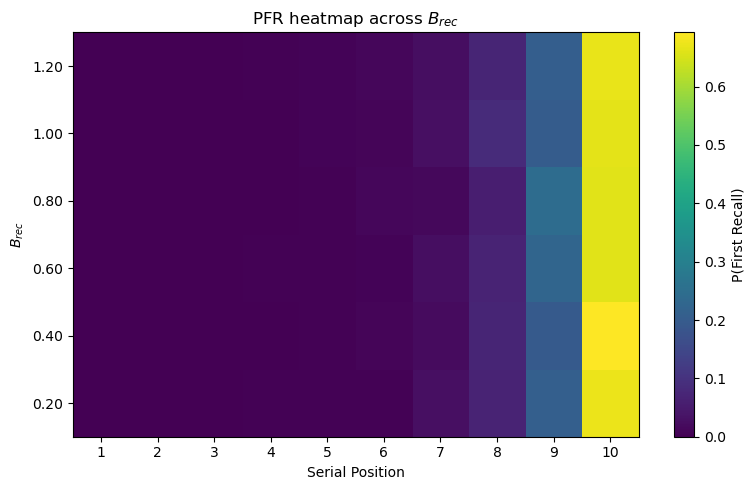

In [83]:
plot_pfr_heatmap(
    sweep_B_rec, B_rec_grid,
    param_name=r"$B_{rec}$",
    cmap_name="viridis",
    show_colorbar=True
)

### SPC curve (probability recalled at each serial position, averaged over sims)

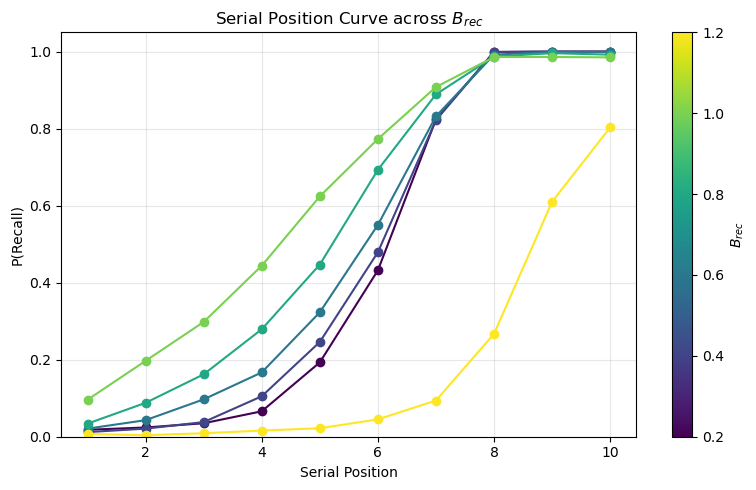

In [84]:
plot_spc_sweep(sweep_B_rec, B_rec_grid, param_name=r"$B_{rec}$")

#### Interpretation

Larger $B_{rec}$ makes retrieval context update more strongly after each recall, strengthening temporal/contiguity-based chaining and improving access to earlier items.

**Trend for $B_{rec}\in[0.2,1.0]$:** Increasing $B_{rec}$ raises recall for early/middle positions (1–6) while late positions (8–10) are near ceiling.

**Why $B_{rec}=1.2$ is different:** When $B_{rec}>1$, context update overshoots, the normalization term becomes invalid, causing qualitatively different dynamics.

#### Why $B_{enc} > 1.0$ is producing abnormal curves

##### First: 
1.	Fetch `trace_sims` for a given grid value
2.	Compute a mean curve across sims even when different sims have different numbers of recall steps (pads with NaNs)

In [96]:
param_grid = np.asarray(B_rec_grid, dtype=float)

def get_trace_sims(sweep_results, val):
    """Robustly retrieve trace_sims for a parameter value."""
    if val in sweep_results:
        return sweep_results[val]["trace_sims"]
    if float(val) in sweep_results:
        return sweep_results[float(val)]["trace_sims"]
    # fallback: match by tolerance (rare but helps if float keys differ)
    for k in sweep_results.keys():
        try:
            if np.isclose(float(k), float(val), atol=1e-12, rtol=0):
                return sweep_results[k]["trace_sims"]
        except Exception:
            pass
    raise KeyError(f"Could not find traces for val={val}")

def mean_curve_over_sims(trace_sims, field):
    """
    field in {"rad","c_norm","cos_after"} etc.
    Returns:
      x: step indices starting at 1
      mean: nanmean across sims at each step
    """
    # keep only valid traces
    ts = [t for t in trace_sims if (t is not None and field in t)]
    if len(ts) == 0:
        return np.array([]), np.array([])
    lens = [len(t[field]) for t in ts]
    T = max(lens)
    M = np.full((len(ts), T), np.nan, dtype=float)
    for i, t in enumerate(ts):
        arr = np.asarray(t[field], dtype=float)
        M[i, :len(arr)] = arr
    mean = np.nanmean(M, axis=0)
    x = np.arange(1, T + 1)
    return x, mean

def mean_scalar_over_sims(trace_sims, field):
    """
    field in {"f_recency_mass","f_entropy"} (logged per retrieval attempt).
    Returns: mean over sims of per-sim mean (robust to variable length).
    """
    vals = []
    for t in trace_sims:
        if t is None or field not in t:
            continue
        arr = np.asarray(t[field], dtype=float)
        if arr.size:
            vals.append(np.nanmean(arr))
    return np.nanmean(vals) if len(vals) else np.nan

##### Plot A. Retrieval context-update radicand across successful recall steps

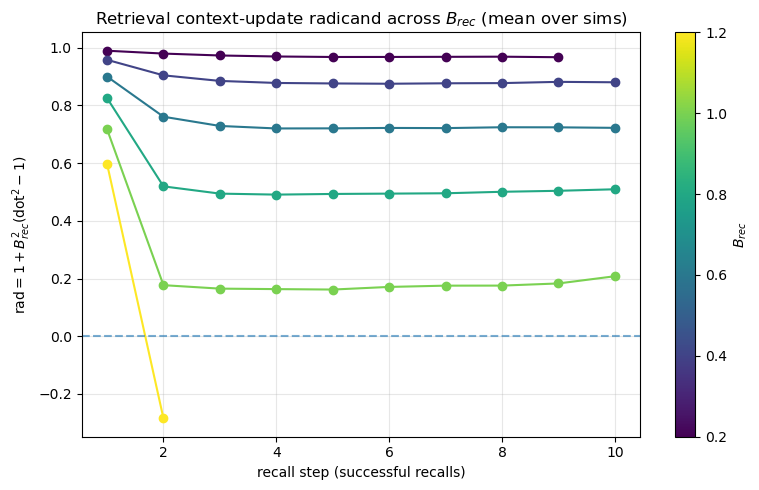

In [97]:
colors, norm, cmap = make_sweep_colors(param_grid, cmap_name="viridis")

plt.figure(figsize=(8, 5))
for B, color in zip(param_grid, colors):
    trace_sims = get_trace_sims(sweep_B_rec, B)
    x, rad_mean = mean_curve_over_sims(trace_sims, "rad")
    if x.size:
        plt.plot(x, rad_mean, marker="o", color=color)

plt.axhline(0, linestyle="--", alpha=0.6)
plt.title(r"Retrieval context-update radicand across $B_{rec}$ (mean over sims)")
plt.xlabel("recall step (successful recalls)")
plt.ylabel(r"$\mathrm{rad} = 1 + B_{rec}^2(\mathrm{dot}^2 - 1)$")
plt.grid(alpha=0.3)
plt.tight_layout()

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig = plt.gcf()
ax = plt.gca()
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r"$B_{rec}$")

plt.show()

At each successful recall step $k$, the retrieval context update uses
$$
\rho_k = \sqrt{\mathrm{rad}_k} - B_{rec}\,\mathrm{dot}_k,
\qquad
\mathrm{dot}_k = c_k^\top c_{in,k},
$$
where the *radicand* is
$$
\mathrm{rad}_k = 1 + B_{rec}^2(\mathrm{dot}_k^2 - 1)
              = 1 - B_{rec}^2\big(1-\mathrm{dot}_k^2\big).
$$
This figure plots $\mathbb{E}[\mathrm{rad}_k]$ across simulations for each $B_{rec}$.
 
- $\mathrm{rad}_k \ge 0$ implies $\sqrt{\mathrm{rad}_k}$ is real and the update is mathematically valid.  
- $\mathrm{rad}_k < 0$ implies an invalid (non-real) normalization term, producing NaNs.  
- Larger $B_{rec}$ pushes $\mathrm{rad}_k$ downward because $(\mathrm{dot}_k^2-1)\le 0$.

**Why $B_{rec}=1.2$ flips sign after step 1:** 
- $\mathrm{rad}_k$ depends on $\mathrm{dot}_k$, which changes after each recall update. 
- The invalidity threshold is $\mathrm{rad}_k<0 \;\Longleftrightarrow\; |\mathrm{dot}_k| < \sqrt{1-\frac{1}{B_{rec}^2}}$. 
- For $B_{rec}=1.2$, this threshold is $\approx 0.553$. 
- Step 1 stays valid if $|\mathrm{dot}_1|$ is often above this value, while step 2 becomes invalid if $|\mathrm{dot}_2|$ often drops below it.

**Why the $B_{rec}=0.2$ curve loses the 10th point:** 
- No simulations reach a 10th successful recall, then the mean at step 10 is NaN.

##### Plot B. Context norm after each retrieval update across $B_{rec}$

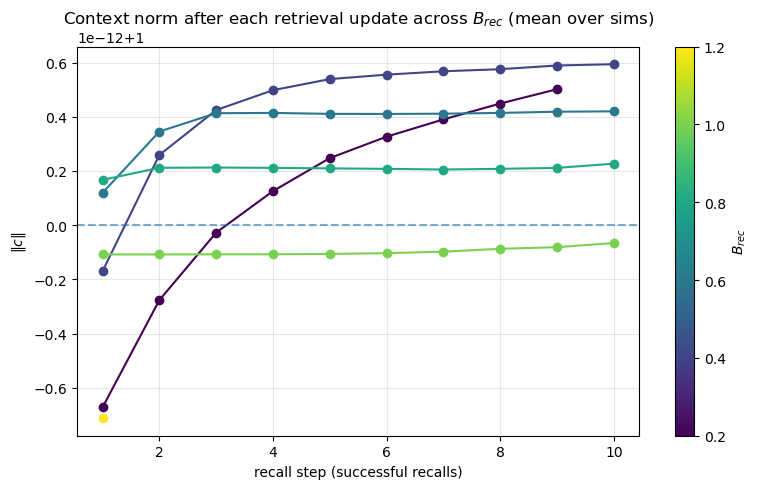

In [98]:
colors, norm, cmap = make_sweep_colors(param_grid, cmap_name="viridis")

plt.figure(figsize=(8, 5))
for B, color in zip(param_grid, colors):
    trace_sims = get_trace_sims(sweep_B_rec, B)
    x, cn_mean = mean_curve_over_sims(trace_sims, "c_norm")
    if x.size:
        plt.plot(x, cn_mean, marker="o", color=color)

plt.axhline(1, linestyle="--", alpha=0.6)
plt.title(r"Context norm after each retrieval update across $B_{rec}$ (mean over sims)")
plt.xlabel("recall step (successful recalls)")
plt.ylabel(r"$\|c\|$")
plt.grid(alpha=0.3)
plt.tight_layout()

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig = plt.gcf()
ax = plt.gca()
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r"$B_{rec}$")

plt.show()

This plot tracks the context-vector norm $\lVert c\rVert$ **after each successful retrieval context update**. 
- The update is expected to keep context normalized, so a stable regime should satisfy $\lVert c\rVert \approx 1$.
- Here, the y-axis uses scientific notation (small text near top), indicating the plotted values are $\lVert c\rVert \approx 1.0$ with deviations on the order of $10^{-12}$. 

**Why $B_{rec}=1.2$ does not appear:**  
- When $\mathrm{rad}<0$, $\rho=\sqrt{\mathrm{rad}}-B_{rec}\mathrm{dot}$ becomes invalid, causing NaNs in $c$ and therefore NaNs in $\|c\|$. 
- Matplotlib does not draw curves consisting of NaNs.

###  lag-CRP (transition probabilities by lag, averaged)

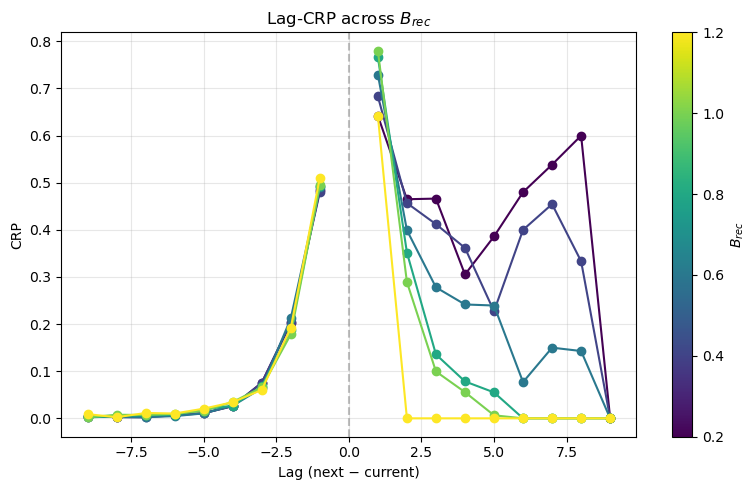

In [127]:
plot_lag_crp_sweep(sweep_B_rec, B_rec_grid, param_name=r"$B_{rec}$")

Lag-CRP plots the probability of a recall transition with lag = (next serial position − current serial position), *conditional* on that lag being possible given remaining unrecalled items. 
- Positive lags are forward transitions
- Negative lags are backward transitions

**Effect of $B_{rec}$:** 
- As $B_{rec}$ increases (up to ~1.0), the peak at lag = +1 grows and probabilities at larger lags shrink. 
    
- consistent with stronger temporal contiguity

#### Why $B_{rec}≤0.6$ shows larger variance at Lag ≥ 4

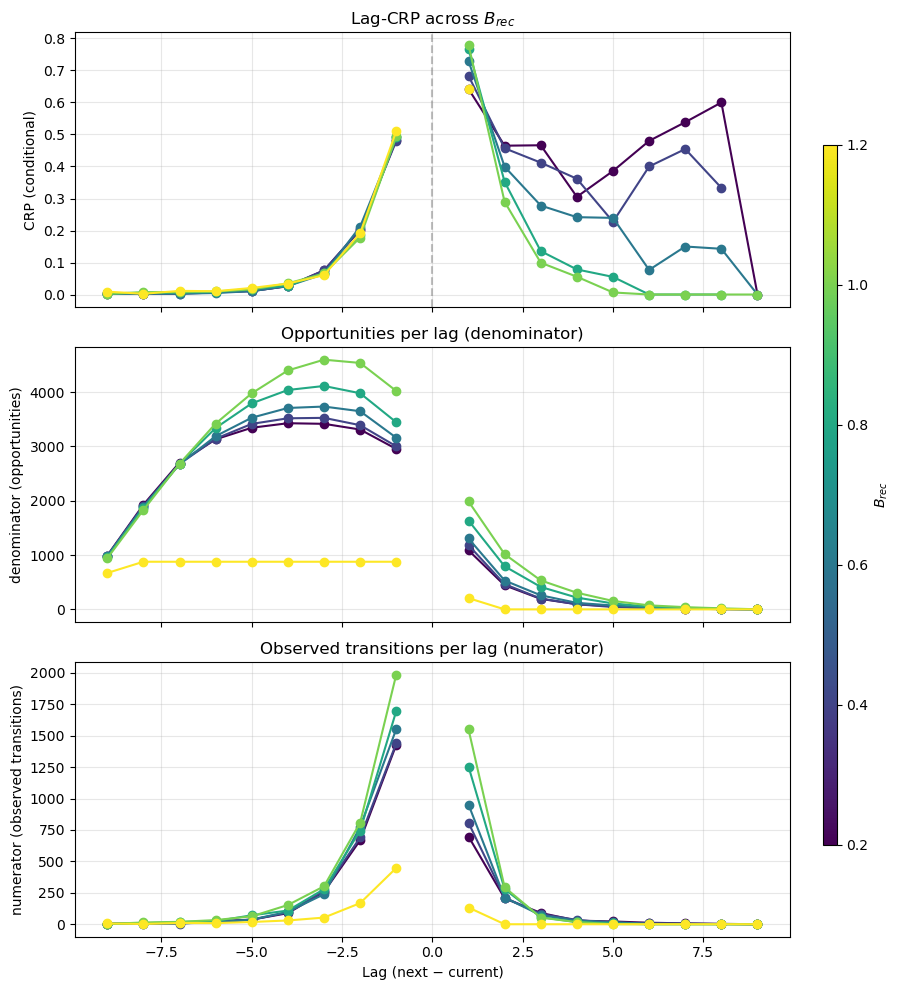

In [136]:
plot_lag_crp_diagnostics(sweep_B_rec, param_grid, param_name=r"$B_{rec}$")


- Though $\mathrm{num}(\ell)$ and $\mathrm{den}(\ell)$ change smoothly, the ratio becomes high-variance when $\mathrm{den}(\ell)$ is small. 
- Tail CRP should be interpreted cautiously or masked when $\mathrm{den}(\ell)$ is below a minimum threshold.

#### Why $B_{rec}≤0.6$ shows increases at Lag ≥4
    
- With weak retrieval context updating, *contiguity is weaker*, so model makes more jump transitions (toward late-list/recency items)
- sparsity in these bins amplifies the upticks

##### A) Unconditional lag rates across $B_{enc}$

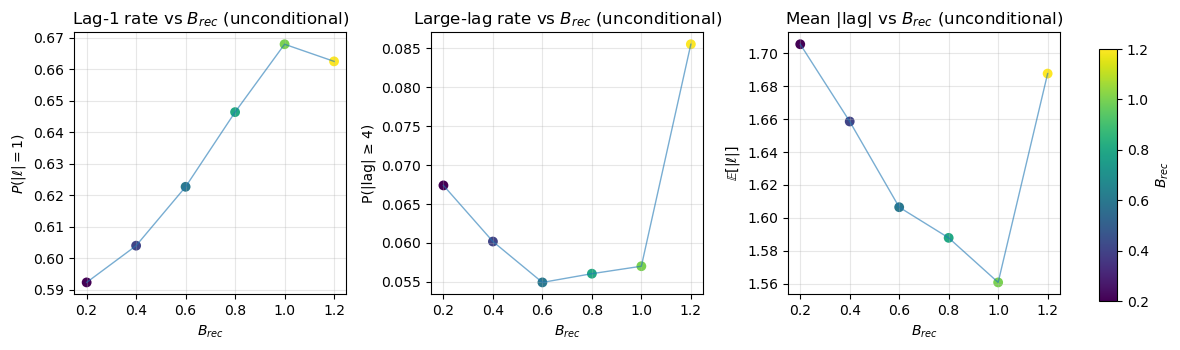

In [164]:
plot_lagOne_largeLag_rates(
    sweep_B_rec, B_rec_grid, param_label=r"$B_{rec}$",
    N=N, large_lag_thresh=4, conditional=False
)

##### B) Conditional lag rates across $B_{enc}$

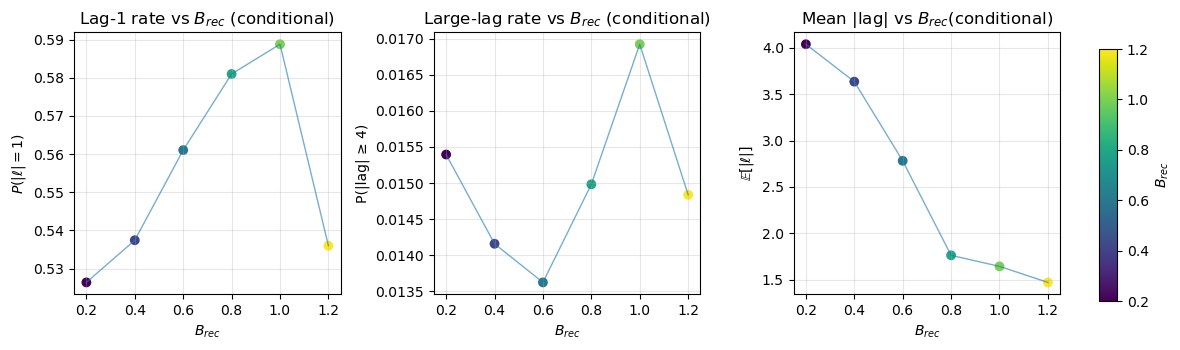

In [165]:
plot_lagOne_largeLag_rates(
    sweep_B_rec, B_rec_grid, param_label=r"$B_{rec}$",
    N=N, large_lag_thresh=4, conditional=True
)

### Cosine similarity $\cos(c, c_{in})$ after update

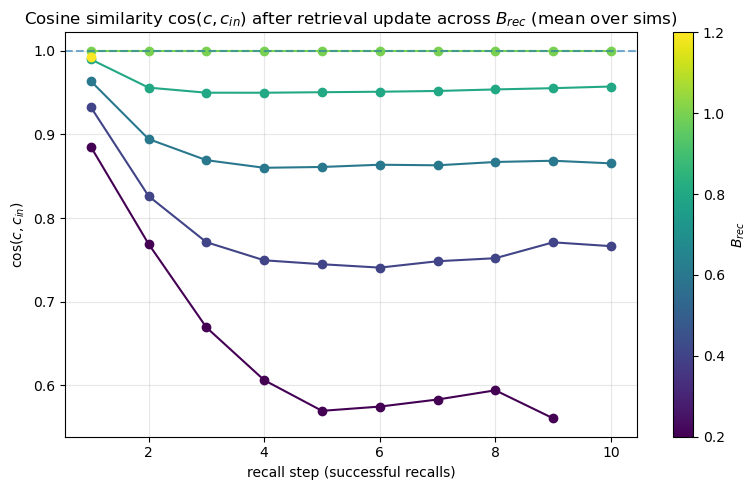

In [99]:
colors, norm, cmap = make_sweep_colors(param_grid, cmap_name="viridis")

plt.figure(figsize=(8, 5))
for B, color in zip(param_grid, colors):
    trace_sims = get_trace_sims(sweep_B_rec, B)
    x, ca_mean = mean_curve_over_sims(trace_sims, "cos_after")
    if x.size:
        plt.plot(x, ca_mean, marker="o", color=color)

plt.axhline(1, linestyle="--", alpha=0.6)
plt.title(r"Cosine similarity $\cos(c,c_{in})$ after retrieval update across $B_{rec}$ (mean over sims)")
plt.xlabel("recall step (successful recalls)")
plt.ylabel(r"$\cos(c, c_{in})$")
plt.grid(alpha=0.3)
plt.tight_layout()

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig = plt.gcf()
ax = plt.gca()
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r"$B_{rec}$")

plt.show()

For each successful recall step $k$ in each simulation, the model computes an item-driven context input
$$
c_{in}=\frac{M_{FC}f}{\lVert M_{FC}f\rVert}
$$
updates context during retrieval
$$
c \leftarrow \rho\,c + B_{rec}\,c_{in}
$$
and logs the post-update alignment
$$
\cos(c,c_{in})=\frac{c^\top c_{in}}{\lVert c\rVert \lVert c_{in}\rVert}
$$

This figure plots the **mean across simulations** of $\cos(c,c_{in})$ at each recall step $k$.

- Higher values (near 1) indicate stronger alignment of the updated context to the lastest recalled item’s input.
- Increasing $B_{rec}$ shifts curves upward because the update weights $c_{in}$ more strongly.
- Again, $B_{rec} = 1.2 $ does not produce an interpretable curve.

### Cue Advantage

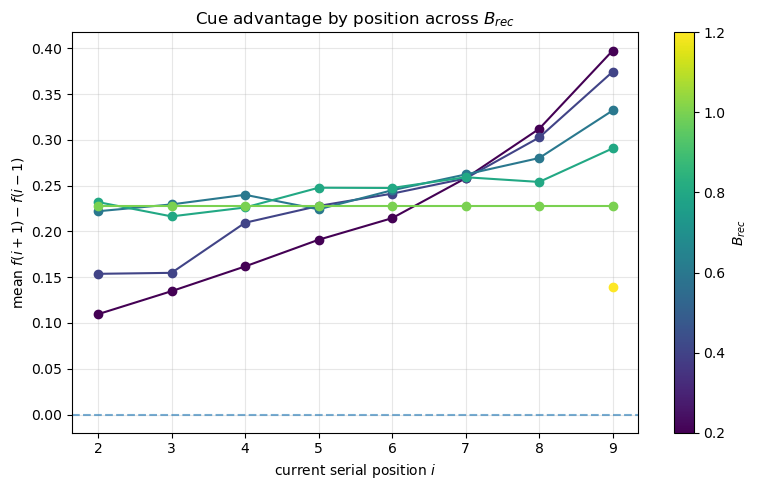

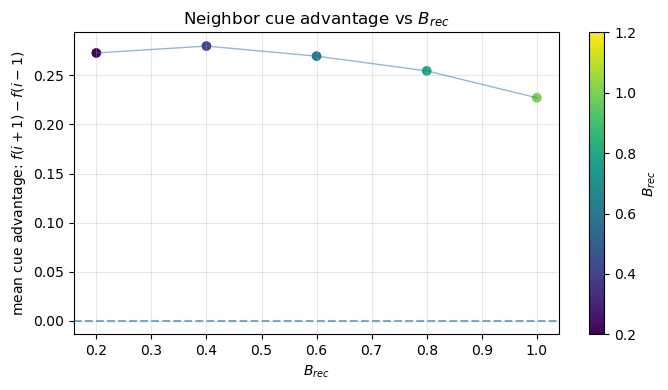

In [ ]:
plot_cue_advantage_by_pos_sweep(
    sweep_B_rec, B_rec_grid, param_name=r"$B_{rec}$", cmap_name="viridis", show_colorbar=True
)

plot_neighbor_advantage_vs_param(
    sweep_B_rec, B_rec_grid, param_name=r"$B_{rec}$", cmap_name="viridis", show_colorbar=True
)

#### Interpretation

**All curves above 0**: 
- Consistent **forward contiguity bias** when both neighbors are available.

**Small $B_{rec}$:** $\Delta f(i)$ increases with $i$ (especially for late positions). 
- With weak retrieval context updating, cues are more influenced by recency-biased context, rather than the currently recalled item's context, so forward neighbors of late-list items receive more support than backward neighbors.

**$B_{rec}\approx 1$:** Curves become flat across $i$. 
- Strong retrieval updating makes the cue dominated by the currently recalled item’s context
- Since both neighbors are symmetrically one step away in temporal context from the currently recalled item, the relative advantage of the +1 vs −1 neighbor becomes more uniform.

### Mean $f_{in}(i)$ by serial position

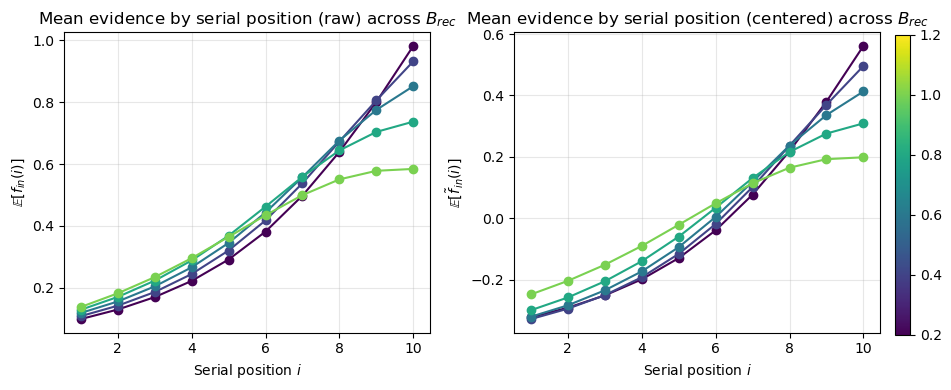

In [125]:
param_grid = np.asarray(B_rec_grid, dtype=float)
colors, norm, cmap = make_sweep_colors(param_grid, cmap_name="viridis")
serial_pos = np.arange(1, N+1)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

for B, color in zip(param_grid, colors):
    ts = get_trace_sims(sweep_B_rec, B)

    f_mean = mean_vector_over_sims(ts, "f_mean_by_pos")
    f_centered = mean_vector_over_sims(ts, "f_mean_centered_by_pos")

    axs[0].plot(serial_pos, f_mean, marker="o", color=color)
    axs[1].plot(serial_pos, f_centered, marker="o", color=color)

axs[0].set_title(r"Mean evidence by serial position (raw) across $B_{rec}$")
axs[0].set_xlabel("Serial position $i$")
axs[0].set_ylabel(r"$\mathbb{E}[f_{in}(i)]$")
axs[0].grid(alpha=0.3)

axs[1].set_title(r"Mean evidence by serial position (centered) across $B_{rec}$")
axs[1].set_xlabel("Serial position $i$")
axs[1].set_ylabel(r"$\mathbb{E}[\tilde f_{in}(i)]$")
axs[1].grid(alpha=0.3)

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cax = fig.add_axes([0.9, 0.15, 0.015, 0.75])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cax)
plt.tight_layout(rect=[0, 0, 0.9, 1])         # leave room on the right
plt.show()

At each retrieval attempt (right before the accumulator): 
- Model computes an evidence vector over items:
$$f_{\text{in}} = M c$$
- Remap evidence to **serial position** $i \in \{1,\dots,N\}$ to yield $f_{\text{in}}(i)$ (since items are presented in a permuted order).

**Left plot**: $\mathbb{E}[f_{\text{in}}(i)]$
- Mean of the pre-accumulator evidence assigned to serial position $i$.
- Larger values mean serial position $i$ tends to receive stronger absolute evidence from the current context (i.e., it is more strongly cued on average), though the scale is not a probability.

**Right plot**: $\mathbb{E}[\tilde f_{\text{in}}(i)]$ where $\tilde f_{\text{in}}(i)= f_{\text{in}}(i) - \frac{1}{N}\sum_{j=1}^{N} f_{\text{in}}(j)$
- Mean of the mean-centered evidence, which removes global additive shifts in evidence magnitude and emphasizes relative differences across serial positions.
- $\mathbb{E}[\tilde f_{\text{in}}(i)]>0$ means position $i$ tends to have above-average evidence relative to other positions within the same retrieval attempt.
- $\mathbb{E}[\tilde f_{\text{in}}(i)]<0$ means position $i$ tends to have below-average evidence relative to other positions within the same retrieval attempt.

**General pattern**:
- Increasing curves indicate *recency-weighted* evidence: context $c$ during retrival is more similar to representations of late-list items across all values of $B_{enc}$.

**Pattern across $B_{rec}$**:
- Higher $B_{rec}$ tends to flatten the late-position advantage (end-of-list evidence is less extreme relative to smaller $B_{rec}$).
- Smaller $B_{rec}$ shows a steeper late-position ramp, meaning stronger recency dominance in evidence.

---
## 2. Sweep strength of feature to context association

In [126]:
sweep_gamma_fc = sweep_one_param(
    param_name="gamma_fc",
    param_grid=gamma_fc_grid,
    base_params=BASE_PARAMS,
    n_sims=n_sims,
    collect_traces=True,   # IMPORTANT
    recency_k=3,
    verbose=True
)

[1/7] gamma_fc=0.2 done (with traces)
[2/7] gamma_fc=0.3 done (with traces)
[3/7] gamma_fc=0.4 done (with traces)
[4/7] gamma_fc=0.5 done (with traces)
[5/7] gamma_fc=0.6 done (with traces)
[6/7] gamma_fc=0.7 done (with traces)
[7/7] gamma_fc=0.8 done (with traces)


### PFR curve (probability of first recall being each serial position, averaged over sims)

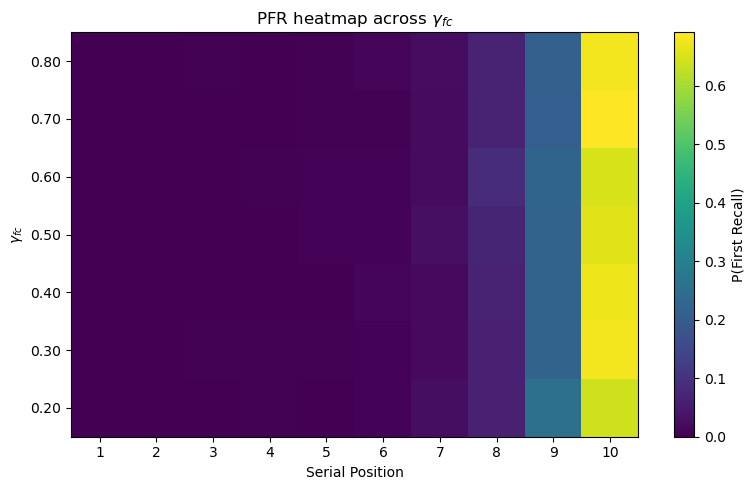

In [ ]:
plot_pfr_heatmap(
    sweep_gamma_fc, gamma_fc_grid,
    param_name=r"$\gamma_{fc}$",
    cmap_name="viridis",
    show_colorbar=True
)

### SPC curve (probability recalled at each serial position, averaged over sims)

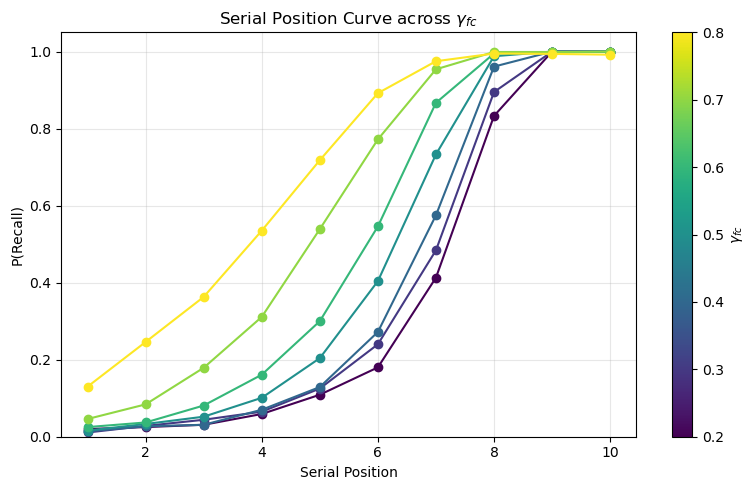

In [ ]:
plot_spc_sweep(sweep_gamma_fc, gamma_fc_grid, param_name=r"$\gamma_{fc}$")

#### Interpretation

- $\gamma_{fc}$ is the learning rate for **context→item** associations. 
- Increasing $\gamma_{fc}$ strengthens how much the current contextual state is written into the cueing matrix for later retrieval.
- Higher $\gamma_{fc}$ makes early items retrievable from contextual cues, reducing a strongly recency-dominated SPC shape.

###  lag-CRP (transition probabilities by lag, averaged over sims)

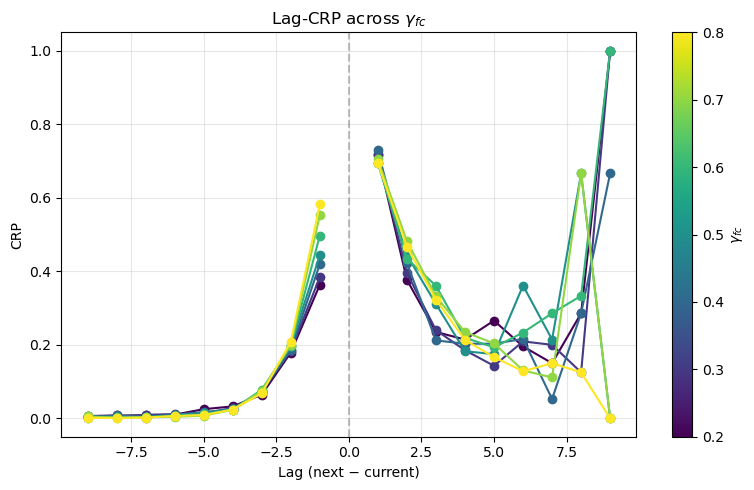

In [ ]:
plot_lag_crp_sweep(sweep_gamma_fc, gamma_fc_grid, param_name=r"$\gamma_{fc}$")

#### Interpretation

Across all $\gamma_{fc}$ values, curves show a strong peak at lag = +1, indicating robust temporal contiguity (stepwise forward chaining).

**Why right-edge spike:** 
- largest positive-lag bin is sparse (few states make such a large jump possible). 
- Because lag-CRP is computed as observed/possible transitions, small denominators produce high-variance estimates; even a few observed large jumps can create an apparent uptick near the maximum lag.


### Cue Advantage

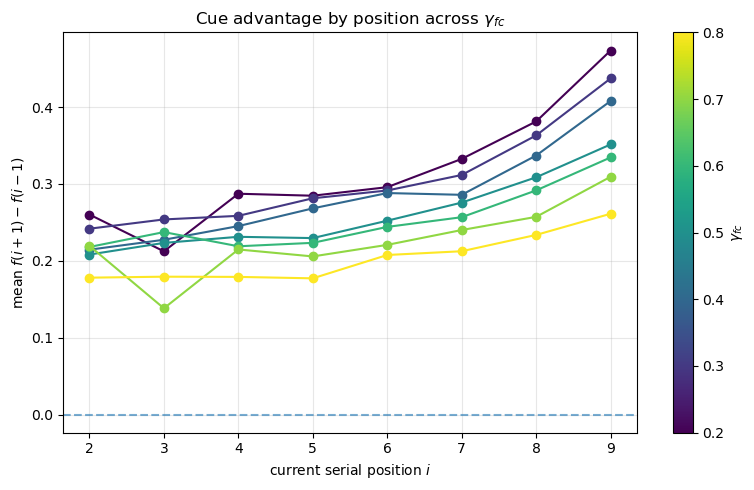

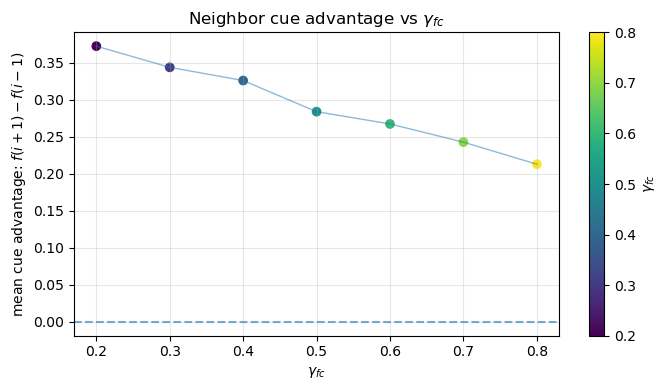

In [ ]:
plot_cue_advantage_by_pos_sweep(
    sweep_gamma_fc, gamma_fc_grid,
    param_name=r"$\gamma_{fc}$",
    cmap_name="viridis",
    show_colorbar=True
)

plot_neighbor_advantage_vs_param(
    sweep_gamma_fc, gamma_fc_grid,
    param_name=r"$\gamma_{fc}$",
    cmap_name="viridis",
    show_colorbar=True
)

---
## 3. Sweep noise level in the decision accumulator.

In [ ]:
sweep_eta = sweep_one_param(
    param_name="eta",
    param_grid=eta_grid,
    base_params=BASE_PARAMS,
    n_sims=n_sims
)

### PFR curve (probability of first recall being each serial position, averaged)

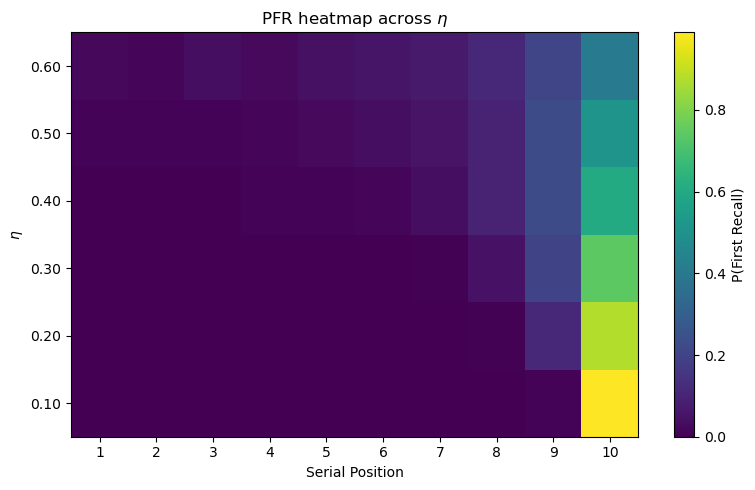

In [ ]:
plot_pfr_heatmap(
    sweep_eta, eta_grid,
    param_name=r"$\eta$",
    cmap_name="viridis",
    show_colorbar=True
)

### SPC curve (probability recalled at each serial position, averaged over sims)

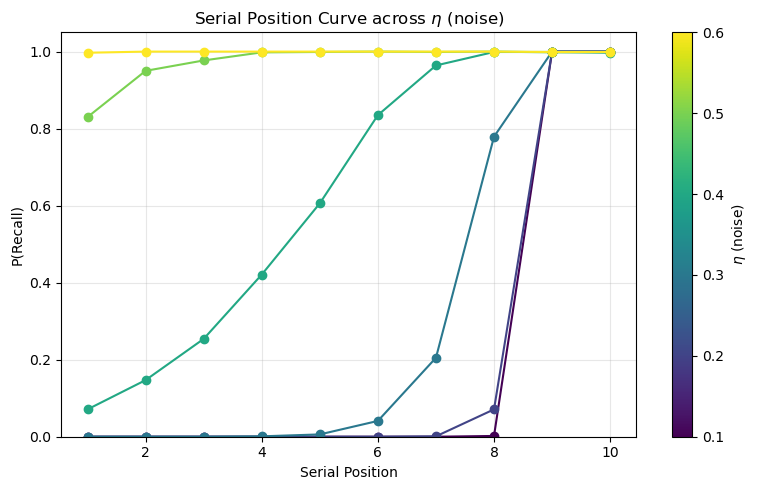

In [ ]:
plot_spc_sweep(sweep_eta, eta_grid, param_name=r"$\eta$ (noise)")

#### Interpretation


**Effect of increasing $\eta$**
- Large eta raises recall across the list and flattens the curve. 
- Higher noise prevents retrieval from being dominated by a small set of high-evidence items.

**Why $P(\mathrm{recall}) \approx 1$ when $\eta=0.6$:** 
- Retrieval becomes highly stochastic
- Model samples broadly among remaining items, making it very likely to eventually recall nearly all items (ceiling SPC).

**Why $P(\mathrm{recall}) \approx 0$ for positions 1–8 when $\eta=0.1$:** 
- Retrieval becomes nearly deterministic/greedy, strongly favoring a small recency-dominated set of items. 
- The process terminates under stop rules before it can reach earlier items, yielding zero recall for positions 1–8.

###  lag-CRP (transition probabilities by lag, averaged)

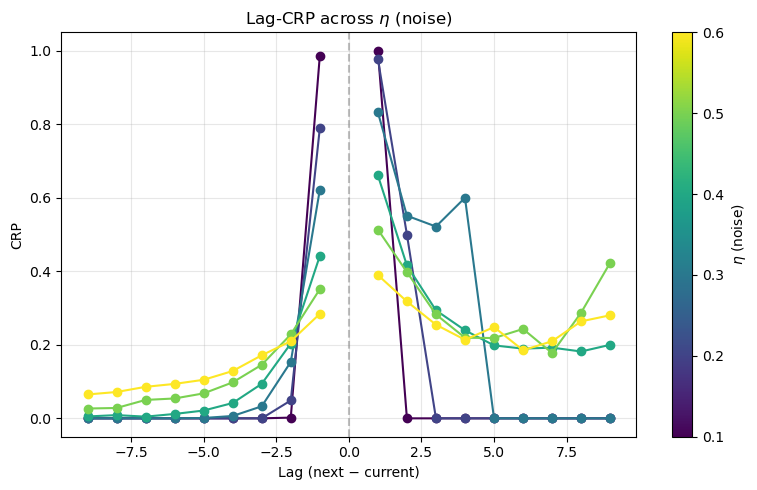

In [ ]:
plot_lag_crp_sweep(sweep_eta, eta_grid, param_name=r"$\eta$ (noise)")

### Cue Advantage

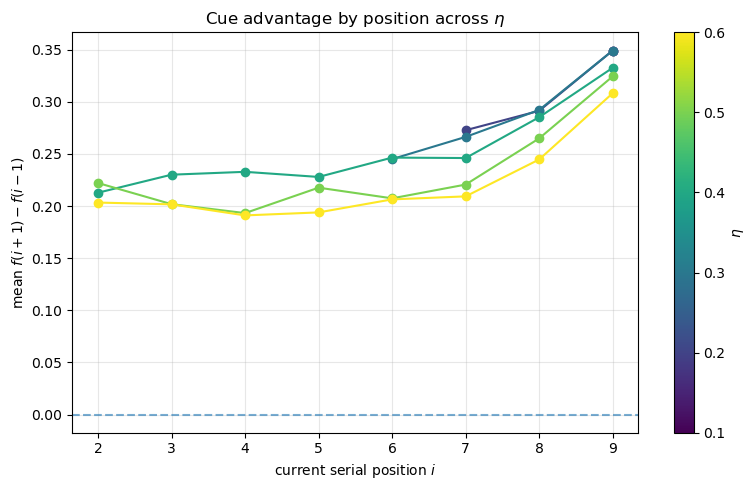

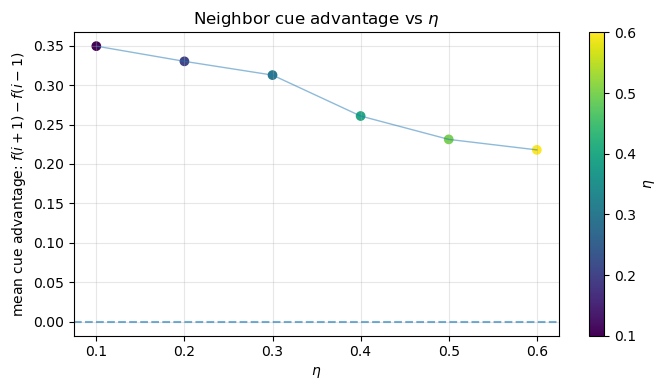

In [ ]:
plot_cue_advantage_by_pos_sweep(
    sweep_eta, eta_grid,
    param_name=r"$\eta$",
    cmap_name="viridis",
    show_colorbar=True
)

plot_neighbor_advantage_vs_param(
    sweep_eta, eta_grid,
    param_name=r"$\eta$",
    cmap_name="viridis",
    show_colorbar=True
)

---

## 4. Sweep scaled global encoding context drift.

In [ ]:
sweep_B_enc_scale = sweep_one_param(
    param_name="B_encD_scale",
    param_grid=B_encD_scale_grid,
    base_params=BASE_PARAMS,
    n_sims=n_sims
)

### PFR curve (probability of first recall being each serial position, averaged)

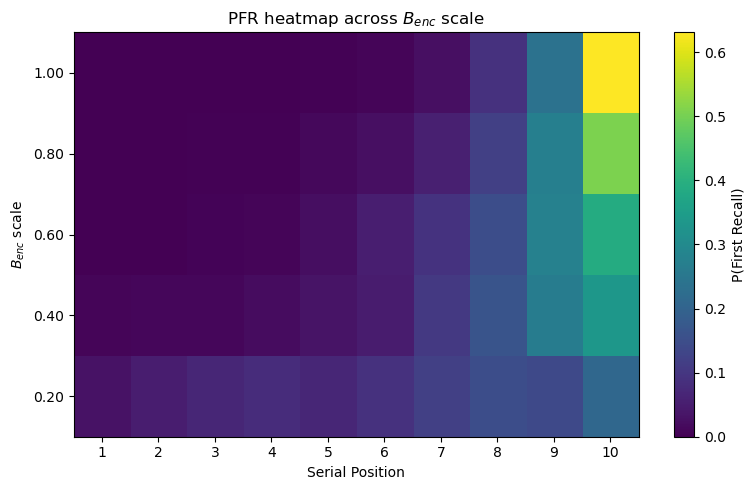

In [ ]:
plot_pfr_heatmap(
    sweep_B_enc_scale, B_encD_scale_grid,
    param_name=r"$B_{enc}$ scale",
    cmap_name="viridis",
    show_colorbar=True
)

### SPC curve (probability recalled at each serial position, averaged over sims)

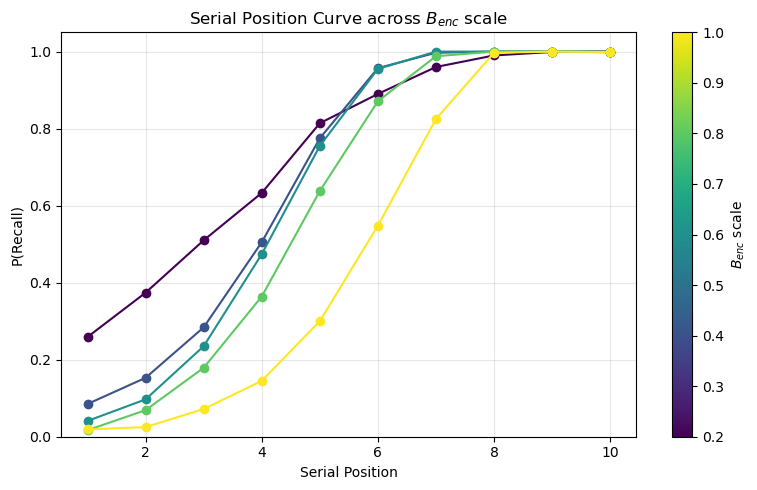

In [ ]:
plot_spc_sweep(sweep_B_enc_scale, B_encD_scale_grid, param_name=r"$B_{enc}$ scale")

### lag-CRP (transition probabilities by lag, averaged)

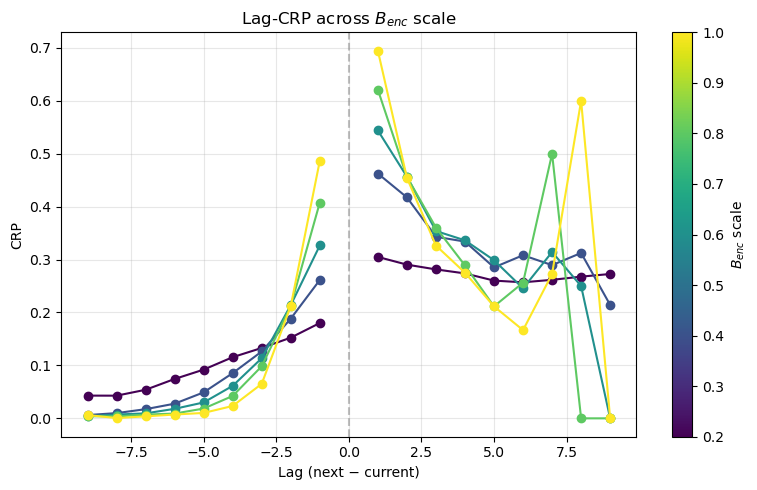

In [ ]:
plot_lag_crp_sweep(sweep_B_enc_scale, B_encD_scale_grid, param_name=r"$B_{enc}$ scale")

### Cue Advantage

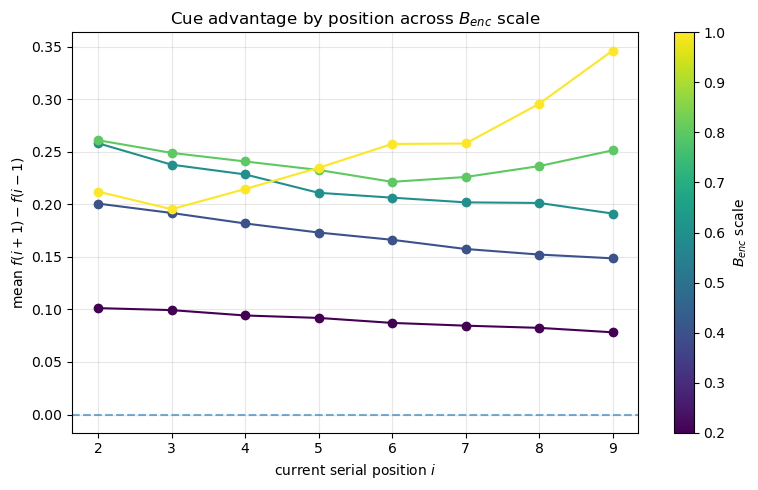

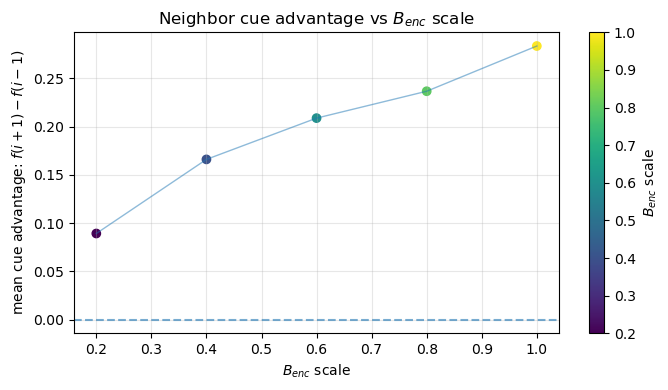

In [ ]:
plot_cue_advantage_by_pos_sweep(
    sweep_B_enc_scale, B_encD_scale_grid,
    param_name=r"$B_{enc}$ scale",
    cmap_name="viridis",
    show_colorbar=True
)

plot_neighbor_advantage_vs_param(
    sweep_B_enc_scale, B_encD_scale_grid,
    param_name=r"$B_{enc}$ scale",
    cmap_name="viridis",
    show_colorbar=True
)

---
## To Sweep a New Parameter

```python
# 1. Add to BASE_PARAMS if needed
BASE_PARAMS["new_param"] = default_value

# 2. Add grid
new_param_grid = [val1, val2, val3]

# 3. Modify simulate_single_trial to accept it
def simulate_single_trial(B_rec, rng, new_param_val=None, ...):
    if new_param_val is None:
        new_param_val = BASE_PARAMS["new_param"]
    # Use new_param_val in simulation...

# 4. Run sweep
sweep_results = sweep_one_param("new_param", new_param_grid, BASE_PARAMS)
```